In [1]:
using CSV, DataFrames
using PyPlot, LaTeXStrings, PyCall
using Interpolations, Distributions, Dierckx

@pyimport numpy as np
@pyimport scienceplots

In [2]:
# 船体に働く流体力
function X_H(u, v, r)
    U = sqrt((u^2) + ((v - r * x_G)^2))
    if U == 0
        β = 0.0
        r_dash = 0.0
        v_dash = 0.0
    else
        β = asin(-(v - r * x_G) / U)
        r_dash = r * L_pp / U
        v_dash = v / U
    end
    return 0.5 * ρ * L_pp * d * (U^2) * X_H_dash(v_dash, r_dash)
end

function Y_H(u, v, r)
    U = sqrt((u^2) + ((v - r * x_G)^2))
    if U == 0
        β = 0.0
        r_dash = 0.0
        v_dash = 0.0
    else
        β = asin(-(v - r * x_G) / U)
        r_dash = r * L_pp / U
        v_dash = v / U
    end
    return 0.5 * ρ * L_pp * d * (U^2) * Y_H_dash(v_dash, r_dash)
end

function N_H(u, v, r)
    U = sqrt((u^2) + ((v - r * x_G)^2))
    if U == 0
        β = 0.0
        r_dash = 0.0
        v_dash = 0.0
    else
        β = asin(-(v - r * x_G) / U)
        r_dash = r * L_pp / U
        v_dash = v / U
    end
    return 0.5 * ρ * (L_pp^2) * d * (U^2) * N_H_dash(v_dash, r_dash)
end

# 船体に働く流体力(無次元)
function X_H_dash(v_dash, r_dash)
    return -R_0_dash + X_vv_dash*(v_dash)^2 + X_vr_dash*v_dash*r_dash + X_rr_dash*(r_dash^2) + X_vvvv_dash*(v_dash^4)
end

function Y_H_dash(v_dash, r_dash)
    return Y_v_dash*v_dash + Y_r_dash*r_dash + Y_vvr_dash*(v_dash)^2*r_dash + Y_vrr_dash*v_dash*r_dash^2 + Y_vvv_dash*(v_dash^3) + Y_rrr_dash*r_dash^3
end

function N_H_dash(v_dash, r_dash)
    return N_v_dash*v_dash + N_r_dash*r_dash + N_vvr_dash*(v_dash^2)*r_dash + N_vrr_dash*v_dash*r_dash^2 + N_vvv_dash*(v_dash^3) + N_rrr_dash*r_dash^3
end

# 舵に働く力
function X_R(u, v, r, δ, n_p)
    return -(1 - t_R) * F_N(u, v, r, δ, n_p) * sin(δ)
end

function Y_R(u, v, r, δ, n_p)
    return -(1 + a_H) * F_N(u, v, r, δ, n_p) * cos(δ)
end

function N_R(u, v, r, δ, n_p)
    return -(x_R + a_H * x_H) * F_N(u, v, r, δ, n_p) * cos(δ)
end

function F_N(u, v, r, δ, n_p)
    U = sqrt((u^2) + ((v - r * x_G)^2))
    if U == 0
        β = 0.0
        r_dash = 0.0
        v_dash = 0.0
    else
        β = asin(-(v - r * x_G) / U)
        r_dash = r * L_pp / U
        v_dash = v / U
    end
    w_P = w_P0 * exp(-4.0 * (β - x_P * r_dash)^2)
    u_p = (1 - w_P) * u
    if J(u, v, r, n_p) == 0.0
        u_R = sqrt(η * (κ * ϵ * 8.0 * k_0 * n_p^2 * D_p^4 / pi)^2)
    else
        u_R = u * (1.0 - w_P) * ϵ * sqrt(η * (1.0 + κ * (sqrt(1.0 + 8.0 * K_T(u, v, r, n_p) / (pi * J(u, v, r, n_p)^2)) - 1))^2 + (1 - η))
    end
    β_R = β - l_R * r_dash
    if β_R < 0.0
        γ_R = γ_R_minus
    else
        γ_R = γ_R_plus
    end 
    v_R = U * γ_R * β_R
    α_R = δ - atan(v_R, u_R)
    U_R = sqrt(u_R^2 + v_R^2)
    return 0.5 * ρ * A_R * (U_R^2) * f_α * sin(α_R)
end

# プロペラに働く力
function X_P(u, v, r, δ, n_p)
    return (1 - t_P) * T_P(u, v, r, n_p)
end

function K_T(u, v, r, n_p)
    return k_0 + k_1 * J(u, v, r, n_p) + k_2 * (J(u, v, r, n_p)^2)
end

function J(u, v, r, n_p)
    U = sqrt((u^2) + ((v - r * x_G)^2))
    if U == 0
        β = 0.0
        r_dash = 0.0
        v_dash = 0.0
    else
        β = asin(-(v - r * x_G) / U)
        r_dash = r * L_pp / U
        v_dash = v / U
    end
    w_P = w_P0 * exp(-4.0 * (β - x_P * r_dash)^2)
    return u * (1 - w_P) / (n_p * D_p)
end

function T_P(u, v, r, n_p)
    return K_T(u, v, r, n_p) * ρ * n_p^2 * D_p^4
end

function X_wind(u, v, ψ, U_W, Ψ_W)
    ρ_air = 1.225
    u_A = u + U_W*cos(Ψ_W-ψ)
    v_A = v + U_W*sin(Ψ_W-ψ)
    U_A = sqrt(u_A^2 + v_A^2)
    Ψ_A = -atan(v_A, u_A)
    Ψ_A = mod(Ψ_A, 2 * π)
    return ρ_air * A_F * spl_C_X(Ψ_A) / 2 * U_A^2
end

function Y_wind(u, v, ψ, U_W, Ψ_W)
    ρ_air = 1.225
    u_A = u + U_W*cos(Ψ_W-ψ)
    v_A = v + U_W*sin(Ψ_W-ψ)
    U_A = sqrt(u_A^2 + v_A^2)
    Ψ_A = -atan(v_A, u_A)
    Ψ_A = mod(Ψ_A, 2 * π)
    return ρ_air * A_L * spl_C_Y(Ψ_A) / 2 * U_A^2
end

function N_wind(u, v, ψ, U_W, Ψ_W)
    ρ_air = 1.225
    u_A = u + U_W*cos(Ψ_W-ψ)
    v_A = v + U_W*sin(Ψ_W-ψ)
    U_A = sqrt(u_A^2 + v_A^2)
    Ψ_A = -atan(v_A, u_A)
    Ψ_A = mod(Ψ_A, 2 * π)
    return ρ_air * A_L * L_pp * spl_C_N(Ψ_A) / 2 * U_A^2
end

function wind_force_and_moment_coefficients(
    ψ_A,
    L_pp,
    B,
    A_OD,
    A_F,
    A_L,
    H_BR,
    H_C,
    C,
)
    #C_LF1の場合で調整
    C_CF = 0.404 + 0.368 * A_F / (B * H_BR) + 0.902 * H_BR / L_pp

    if deg2rad(0) <= ψ_A <= deg2rad(90)
        C_LF = -0.992 + 0.507 * A_L / (L_pp * B) + 1.162 * C / L_pp
        C_XLI = 0.458 + 3.245 * A_L / (L_pp * H_BR) - 2.313 * A_F / (B * H_BR)
        C_ALF = -0.585 - 0.906 * A_OD / A_L + 3.239 * B / L_pp
        C_YLI = pi * A_L / L_pp^2 + 0.116 + 3.345 * A_F / (L_pp * B)

        C_X = C_LF * cos(ψ_A) + C_XLI * (sin(ψ_A) - sin(ψ_A) * cos(ψ_A)^2 / 2) * sin(ψ_A) * cos(ψ_A) + C_ALF * sin(ψ_A) * cos(ψ_A)^3
        C_Y = C_CF * sin(ψ_A)^2 + C_YLI * (cos(ψ_A) + sin(ψ_A)^2 * cos(ψ_A) / 2) * sin(ψ_A) * cos(ψ_A)
        C_N = C_Y * (0.297 * C / L_pp - 0.149 * (ψ_A - deg2rad(90)))

    elseif deg2rad(90) < ψ_A <= deg2rad(180)
        C_LF =
            0.018 - 5.091 * B / L_pp + 10.367 * H_C / L_pp - 3.011 * A_OD / L_pp^2 -
            0.341 * A_F / B^2
        C_XLI =
            -1.901 + 12.727 * A_L / (L_pp * H_BR) + 24.407 * A_F / A_L -
            40.310 * B / L_pp - 0.341 * A_F / (B * H_BR)
        C_ALF = -0.314 - 1.117 * A_OD / A_L
        C_YLI = pi * A_L / L_pp^2 + 0.446 + 2.192 * A_F / L_pp^2

        C_X = C_LF * cos(ψ_A) + C_XLI * (sin(ψ_A) - sin(ψ_A) * cos(ψ_A)^2 / 2) * sin(ψ_A) * cos(ψ_A) + C_ALF * sin(ψ_A) * cos(ψ_A)^3
        C_Y = C_CF * sin(ψ_A)^2 + C_YLI * (cos(ψ_A) + sin(ψ_A)^2 * cos(ψ_A) / 2) * sin(ψ_A) * cos(ψ_A)
        C_N = C_Y * (0.297 * C / L_pp - 0.149 * (ψ_A - deg2rad(90)))

    elseif deg2rad(180) < ψ_A <= deg2rad(270)
        C_LF =
            0.018 - 5.091 * B / L_pp + 10.367 * H_C / L_pp - 3.011 * A_OD / L_pp^2 -
            0.341 * A_F / B^2
        C_XLI =
            -1.901 + 12.727 * A_L / (L_pp * H_BR) + 24.407 * A_F / A_L -
            40.310 * B / L_pp - 0.341 * A_F / (B * H_BR)
        C_ALF = -0.314 - 1.117 * A_OD / A_L
        C_YLI = pi * A_L / L_pp^2 + 0.446 + 2.192 * A_F / L_pp^2
        ψ_A = 2*pi - ψ_A
        C_X = (C_LF * cos(ψ_A) + C_XLI * (sin(ψ_A) - sin(ψ_A) * cos(ψ_A)^2 / 2) * sin(ψ_A) * cos(ψ_A) + C_ALF * sin(ψ_A) * cos(ψ_A)^3)
        C_Y = -(C_CF * sin(ψ_A)^2 + C_YLI * (cos(ψ_A) + sin(ψ_A)^2 * cos(ψ_A) / 2) * sin(ψ_A) * cos(ψ_A))
        C_N = (C_Y * (0.297 * C / L_pp - 0.149 * (ψ_A - deg2rad(90))))
    
    elseif deg2rad(270) < ψ_A <= deg2rad(360)
        C_LF = -0.992 + 0.507 * A_L / (L_pp * B) + 1.162 * C / L_pp
        C_XLI = 0.458 + 3.245 * A_L / (L_pp * H_BR) - 2.313 * A_F / (B * H_BR)
        C_ALF = -0.585 - 0.906 * A_OD / A_L + 3.239 * B / L_pp
        C_YLI = pi * A_L / L_pp^2 + 0.116 + 3.345 * A_F / (L_pp * B)

        ψ_A = 2*pi - ψ_A
        C_X = (C_LF * cos(ψ_A) + C_XLI * (sin(ψ_A) - sin(ψ_A) * cos(ψ_A)^2 / 2) * sin(ψ_A) * cos(ψ_A) + C_ALF * sin(ψ_A) * cos(ψ_A)^3)
        C_Y = -(C_CF * sin(ψ_A)^2 + C_YLI * (cos(ψ_A) + sin(ψ_A)^2 * cos(ψ_A) / 2) * sin(ψ_A) * cos(ψ_A))
        C_N = (C_Y * (0.297 * C / L_pp - 0.149 * (ψ_A - deg2rad(90))))
    end
    
    C_X, C_Y, C_N
end

function MMG(x_0, X_F, Y_F, N_F, X_wind, Y_wind, N_wind, δ, n_p)
    u = x_0[1] + dt * ((X_H(x_0[1], x_0[2], x_0[3]) + X_R(x_0[1], x_0[2], x_0[3], δ, n_p) + X_P(x_0[1], x_0[2], x_0[3], δ, n_p) + X_F + X_wind + (m + m_y) * x_0[2] * x_0[3]) / (m + m_x))
    u = isfinite(u) ? u : 0.0
    v = x_0[2] + dt * ((Y_H(x_0[1], x_0[2], x_0[3]) + Y_R(x_0[1], x_0[2], x_0[3], δ, n_p) + Y_F + Y_wind - (m + m_x) * x_0[1] * x_0[3]) / (m + m_y))
    v = isfinite(v) ? v : 0.0
    r = x_0[3] + dt * ((N_H(x_0[1], x_0[2], x_0[3]) + N_R(x_0[1], x_0[2], x_0[3], δ, n_p) + N_F + N_wind) / (I_zG + J_z))
    r = isfinite(r) ? r : 0.0
    x = x_0[6] + dt * (x_0[1] * cos(x_0[8]) - x_0[2] * sin(x_0[8]))
    x = isfinite(x) ? x : 0.0
    y = x_0[7] + dt * (x_0[1] * sin(x_0[8]) + x_0[2] * cos(x_0[8]))
    y = isfinite(y) ? y : 0.0
    ψ = x_0[8] + dt * (x_0[3])
    ψ = isfinite(ψ) ? ψ : 0.0
    x1 = x + L_f * cos(ψ)
    x1 = isfinite(x1) ? x1 : 0.0
    y1 = y + L_f * sin(ψ)
    y1 = isfinite(y1) ? y1 : 0.0
    x2 = x + L_t * cos(ψ + pi)
    x2 = isfinite(x2) ? x2 : 0.0
    y2 = y + L_t * sin(ψ + pi)
    y2 = isfinite(y2) ? y2 : 0.0
    return u, v, r, δ, n_p, x, y, ψ, x1, y1, x2, y2
end

ρ = 1025.0
L_pp = 7.00  # 船長Lpp[m]
B = 1.27  # 船幅[m]
d = 0.46  # 喫水[m]
nabla = 3.27  # 排水量[m^3]
x_G = 0.25  # 重心位置[m]
# C_b = 0.810  # 方形係数[-]
D_p = 0.216  # プロペラ直径[m]
H_R = 0.345  # 舵高さ[m]
A_R = 0.0539  # 舵断面積[m^2]
t_P = 0.220  # 推力減少率
w_P0 = 0.40  # 有効伴流率
m_x_dash = 0.022  # 付加質量x(無次元)
m_y_dash = 0.223  # 付加質量y(無次元)
J_z_dash = 0.011  # 付加質量Izz(無次元)
t_R = 0.387  # 操縦抵抗減少率
x_R_dash = -0.500  # 舵の相対位置
a_H = 0.312  # 舵力増加係数
x_H_dash = -0.464  # 舵力増分作用位置
γ_R_minus = 0.395  # 整流係数
γ_R_plus = 0.640  # 整流係数
l_r_dash = -0.710  # 船長に対する舵位置
x_P_dash = -0.690  # 船長に対するプロペラ位置
ϵ = 1.09  # プロペラ・舵位置伴流係数比
κ = 0.50  # 修正係数
f_α = 2.747  # 直圧力勾配係数

L_pp = L_pp  # 船長Lpp[m]
B = B  # 船幅[m]
d = d  # 喫水[m]
x_G = x_G  # 重心位置[]
D_p = D_p  # プロペラ直径[m]
m = ρ * nabla  # 質量(無次元化)[kg]
I_zG = ρ * nabla * ((0.25 * L_pp)^2)  # 慣性モーメント[-]
A_R = A_R  # 船の断面に対する舵面積比[-]
η = D_p / H_R  # プロペラ直径に対する舵高さ(Dp/H)
m_x = (0.5 * ρ * (L_pp^2) * d) * m_x_dash  # 付加質量x(無次元)
m_y = (0.5 * ρ * (L_pp^2) * d) * m_y_dash  # 付加質量y(無次元)
J_z = (0.5 * ρ * (L_pp^4) * d) * J_z_dash  # 付加質量Izz(無次元)
f_α = f_α # 直圧力勾配係数
ϵ = ϵ  # プロペラ・舵位置伴流係数比
t_R = t_R  # 操縦抵抗減少率
x_R = x_R_dash * L_pp  # 舵の位置
a_H = a_H  # 舵力増加係数
x_H = x_H_dash * L_pp  # 舵力増分作用位置
γ_R_minus = γ_R_minus  # 整流係数
γ_R_plus = γ_R_plus  # 整流係数
l_R = l_r_dash  # 船長に対する舵位置
κ = κ  # 修正係数
t_P = t_P  # 推力減少率
w_P0 = w_P0  # 有効伴流率
x_P = x_P_dash  # 船長に対するプロペラ位置

const k_0 = 0.2931
const k_1 = -0.2753
const k_2 = -0.1385

L_f = 3.0
L_t = 3.0

D = 0.6563 # 深さ[m]
A_OD = 0.65 # デッキ上の構造物の側面投影面積[m^2]
H_BR = 0.85 # 喫水からブリッジ主要構造物の最高位[m]
H_C = 0.235 # 喫水から側面積中心までの高さ[m]
C = 0.0 # 船体中心から側面積中心までの前後方向座標(船首方向を正)[m]

A_OD = A_OD # デッキ上の構造物の側面投影面積[m^2]
A_F = (D - d) * B  # 船体の正面投影面積[m^2]
A_L = (D - d) * L_pp # 船体の側面投影面積[m^2]
H_BR = H_BR # 喫水からブリッジ主要構造物の最高位[m]
H_C = H_C # 喫水から側面積中心までの高さ[m]
C = C # 船体中心から側面積中心までの前後方向座標[m]

ψ_A_vec = deg2rad.(collect(0:10:360))
C_X_vec = Array{Float64}(undef, length(ψ_A_vec))
C_Y_vec = Array{Float64}(undef, length(ψ_A_vec))
C_N_vec = Array{Float64}(undef, length(ψ_A_vec))
for (index, ψ_A) in enumerate(ψ_A_vec)
    C_X, C_Y, C_N = wind_force_and_moment_coefficients(
        ψ_A,
        L_pp,
        B,
        A_OD,
        A_F,
        A_L,
        H_BR,
        H_C,
        C,
    )
    C_X_vec[index] = C_X
    C_Y_vec[index] = C_Y
    C_N_vec[index] = C_N
end
spl_C_X = Spline1D(ψ_A_vec, C_X_vec)
spl_C_Y = Spline1D(ψ_A_vec, C_Y_vec)
spl_C_N = Spline1D(ψ_A_vec, C_N_vec)

function MMG_p(i)
    global R_0_dash, X_vv_dash, X_vr_dash, X_rr_dash, X_vvvv_dash
    global Y_v_dash, Y_r_dash, Y_vvv_dash, Y_vvr_dash, Y_vrr_dash, Y_rrr_dash
    global N_v_dash, N_r_dash, N_vvv_dash, N_vvr_dash, N_vrr_dash, N_rrr_dash
    global x_0, δ_ref, n_p_ref, X_F, Y_F, N_F
    global p

    x_0 = x_1
    # データフレーム
    cols = Int(duration/dt) + 1
    df_x = DataFrame(
        time = collect(0:dt:duration),
        u = zeros(cols),
        v = zeros(cols),
        r = zeros(cols),
        δ = zeros(cols),
        n_p = zeros(cols),
        x = zeros(cols),
        y = zeros(cols),
        ψ = zeros(cols),
        x1 = zeros(cols),
        y1 = zeros(cols),
        x2 = zeros(cols),
        y2 = zeros(cols),
        X_F = zeros(cols),
        Y_F = zeros(cols),
        N_F = zeros(cols),
    )
    #初期値をデータフレームへ
    df_x[1, 2:13] .= x_0
    df_x[1, 14:16] .= [X_F0, Y_F0, N_F0]

    R_0_dash = p[i, 4]
    X_vv_dash = p[i, 5]
    X_vr_dash = p[i, 6]
    X_rr_dash = p[i, 7]
    X_vvvv_dash = p[i, 8]
    Y_v_dash = p[i, 9]
    Y_r_dash = p[i, 10]
    Y_vvv_dash = p[i, 11]
    Y_vvr_dash = p[i, 12]
    Y_vrr_dash = p[i, 13]
    Y_rrr_dash = p[i, 14]
    N_v_dash = p[i, 15]
    N_r_dash = p[i, 16]
    N_vvv_dash = p[i, 17]
    N_vvr_dash = p[i, 18]
    N_vrr_dash = p[i, 19]
    N_rrr_dash = p[i, 20]    

    for t in 1 : Int(duration/dt)
        U_W_t = U_W_list[t]
        Ψ_W_t = Ψ_W_list[t]
    
        X_F_t = X_F_list[t]
        Y_F_t = Y_F_list[t]
        N_F_t = N_F_list[t]
    
        x_F = X_F_t*cos(x_0[8]) + Y_F_t*sin(x_0[8])
        y_F = -X_F_t*sin(x_0[8]) + Y_F_t*cos(x_0[8]) 
        n_F = N_F_t
    
        x_wind = X_wind(x_0[1], x_0[2], x_0[8], U_W_t, Ψ_W_t)
        y_wind = Y_wind(x_0[1], x_0[2], x_0[8], U_W_t, Ψ_W_t)
        n_wind = N_wind(x_0[1], x_0[2], x_0[8], U_W_t, Ψ_W_t)   
    
        x_val = MMG(x_0, x_F, y_F, n_F, x_wind, y_wind, n_wind, δ_list[t], n_p_list[t])
        df_x[t+1, 2:13] .= x_val
        df_x[t+1, 14:16] .= [x_F, y_F, n_F]
        x_0 = collect(x_val) 
    end
    return df_x
end

function MMG_random(i)
    global R_0_dash, X_vv_dash, X_vr_dash, X_rr_dash, X_vvvv_dash
    global Y_v_dash, Y_r_dash, Y_vvv_dash, Y_vvr_dash, Y_vrr_dash, Y_rrr_dash
    global N_v_dash, N_r_dash, N_vvv_dash, N_vvr_dash, N_vrr_dash, N_rrr_dash
    global x_0, δ_ref, n_p_ref, X_F, Y_F, N_F
    global p

    x_0 = x_1
    # データフレーム
    cols = Int(duration/dt) + 1
    df_x2 = DataFrame(
        time = collect(0:dt:duration),
        u = zeros(cols),
        v = zeros(cols),
        r = zeros(cols),
        δ = zeros(cols),
        n_p = zeros(cols),
        x = zeros(cols),
        y = zeros(cols),
        ψ = zeros(cols),
        x1 = zeros(cols),
        y1 = zeros(cols),
        x2 = zeros(cols),
        y2 = zeros(cols),
        X_F = zeros(cols),
        Y_F = zeros(cols),
        N_F = zeros(cols),
    )
    #初期値をデータフレームへ
    df_x2[1, 2:13] .= x_0
    df_x2[1, 14:16] .= [X_F0, Y_F0, N_F0]   

    for t in 1 : Int(duration/dt)
        random_num = rand(500:1000)
        R_0_dash = p[random_num, 4]
        X_vv_dash = p[random_num, 5]
        X_vr_dash = p[random_num, 6]
        X_rr_dash = p[random_num, 7]
        X_vvvv_dash = p[random_num, 8]
        Y_v_dash = p[random_num, 9]
        Y_r_dash = p[random_num, 10]
        Y_vvv_dash = p[random_num, 11]
        Y_vvr_dash = p[random_num, 12]
        Y_vrr_dash = p[random_num, 13]
        Y_rrr_dash = p[random_num, 14]
        N_v_dash = p[random_num, 15]
        N_r_dash = p[random_num, 16]
        N_vvv_dash = p[random_num, 17]
        N_vvr_dash = p[random_num, 18]
        N_vrr_dash = p[random_num, 19]
        N_rrr_dash = p[random_num, 20] 

        U_W_t = U_W_list[t]
        Ψ_W_t = Ψ_W_list[t]
    
        X_F_t = X_F_list[t]
        Y_F_t = Y_F_list[t]
        N_F_t = N_F_list[t]
    
        x_F = X_F_t*cos(x_0[8]) + Y_F_t*sin(x_0[8])
        y_F = -X_F_t*sin(x_0[8]) + Y_F_t*cos(x_0[8]) 
        n_F = N_F_t
    
        x_wind = X_wind(x_0[1], x_0[2], x_0[8], U_W_t, Ψ_W_t)
        y_wind = Y_wind(x_0[1], x_0[2], x_0[8], U_W_t, Ψ_W_t)
        n_wind = N_wind(x_0[1], x_0[2], x_0[8], U_W_t, Ψ_W_t)   
    
        x_val = MMG(x_0, x_F, y_F, n_F, x_wind, y_wind, n_wind, δ_list[t], n_p_list[t])
        df_x2[t+1, 2:13] .= x_val
        df_x2[t+1, 14:16] .= [x_F, y_F, n_F]
        x_0 = collect(x_val) 
    end
    return df_x2
end

MMG_random (generic function with 1 method)

In [3]:
duration = 100 # 全体の計算時間
dt = 0.1 # 刻み幅

whole_step = Int(duration/dt) # 全体のステップ数

U_W = 0.0 # 風速の初期値[m/s]
Ψ_W = 1.0* pi # 風向の初期値[rad]

# 風速が一定のとき
U_W_list = U_W * ones(Float64, whole_step)
Ψ_W_list = Ψ_W * ones(Float64, whole_step)



n_p_ref = 21.21824 # プロペラ回転数[rps]
#回転数一定
n_p_list = n_p_ref * ones(Float64, whole_step)

X_F0 = 0.0 # X方向の外力の初期値[N]
Y_F0 = 0.0 # Y方向の外力の初期値[N]
N_F0 = 0.0 # N方向の外力モーメントの初期値[Nm]

# 外力が一定のとき
X_F_list = X_F0 * ones(Float64, whole_step)
Y_F_list = Y_F0 * ones(Float64, whole_step)
N_F_list = N_F0 * ones(Float64, whole_step)



# データの読み込み
obs = CSV.read("../MPC/observation/obs_EF.csv", DataFrame)
L2_10deg = CSV.read("../MCMC/result/10degL2MCMC_KVLCC2.csv", DataFrame)
L3_10deg = CSV.read("../MCMC/result/10degL3MCMC_KVLCC2.csv", DataFrame)
L2_20deg = CSV.read("../MCMC/result/20degL2MCMC_KVLCC2.csv", DataFrame)
L3_20deg = CSV.read("../MCMC/result/20degL3MCMC_KVLCC2.csv", DataFrame)
L2_35deg = CSV.read("../MCMC/result/35degL2MCMC_KVLCC2.csv", DataFrame)
L3_35deg = CSV.read("../MCMC/result/35degL3MCMC_KVLCC2.csv", DataFrame)
mcmcobs = CSV.read("../MCMC/observation/KVLCC2_35deg_model_data.csv", DataFrame)

num1 = 400
num2 = 700

sampling = Int(duration / dt)

struct SimulationResults1
    data1::Dict{Int, DataFrame}
end
struct SimulationResults2
    data2::Dict{Int, DataFrame}
end
struct SimulationResults3
    data3::Dict{Int, DataFrame}
end
struct SimulationResults4
    data4::Dict{Int, DataFrame}
end
struct SimulationResults5
    data5::Dict{Int, DataFrame}
end
struct SimulationResults6
    data6::Dict{Int, DataFrame}
end
struct SimulationResults7
    data7::Dict{Int, DataFrame}
end
struct SimulationResults8
    data8::Dict{Int, DataFrame}
end
struct SimulationResults9
    data9::Dict{Int, DataFrame}
end
struct SimulationResults10
    data10::Dict{Int, DataFrame}
end
struct SimulationResults11
    data11::Dict{Int, DataFrame}
end
struct SimulationResults12
    data12::Dict{Int, DataFrame}
end

results_L2_10deg = SimulationResults1(Dict{Int, DataFrame}())
results_L2_10deg_r = SimulationResults2(Dict{Int, DataFrame}())
results_L3_10deg = SimulationResults3(Dict{Int, DataFrame}())
results_L3_10deg_r = SimulationResults4(Dict{Int, DataFrame}())
results_L2_20deg = SimulationResults5(Dict{Int, DataFrame}())
results_L2_20deg_r = SimulationResults6(Dict{Int, DataFrame}())
results_L3_20deg = SimulationResults7(Dict{Int, DataFrame}())
results_L3_20deg_r = SimulationResults8(Dict{Int, DataFrame}())
results_L2_35deg = SimulationResults9(Dict{Int, DataFrame}())
results_L2_35deg_r = SimulationResults10(Dict{Int, DataFrame}())
results_L3_35deg = SimulationResults11(Dict{Int, DataFrame}())
results_L3_35deg_r = SimulationResults12(Dict{Int, DataFrame}())

SimulationResults12(Dict{Int64, DataFrame}())

In [4]:
δ_ref =  10 * pi / 180.0
δ_list = δ_ref * ones(Float64, whole_step)
x_1 = Vector(Float64[1.4, 0.0, 0.0, δ_ref, n_p_ref, 0.0, 0.0, 0.0, 3.0, 0.0, -3.0, 0.0])
p = L2_10deg
for i in num1:num2
    results_L2_10deg.data1[i] = MMG_p(i)
    results_L2_10deg_r.data2[i] = MMG_random(i)
end
p = L3_10deg
for i in num1:num2
    results_L3_10deg.data3[i] = MMG_p(i)
    results_L3_10deg_r.data4[i] = MMG_random(i)
end

δ_ref =  20 * pi / 180.0
δ_list = δ_ref * ones(Float64, whole_step)
x_1 = Vector(Float64[1.4, 0.0, 0.0, δ_ref, n_p_ref, 0.0, 0.0, 0.0, 3.0, 0.0, -3.0, 0.0])
p = L2_20deg
for i in num1:num2
    results_L2_20deg.data5[i] = MMG_p(i)
    results_L2_20deg_r.data6[i] = MMG_random(i)
end
p = L3_20deg
for i in num1:num2
    results_L3_20deg.data7[i] = MMG_p(i)
    results_L3_20deg_r.data8[i] = MMG_random(i)
end

δ_ref =  35 * pi / 180.0
δ_list = δ_ref * ones(Float64, whole_step)
x_1 = Vector(Float64[1.4, 0.0, 0.0, δ_ref, n_p_ref, 0.0, 0.0, 0.0, 3.0, 0.0, -3.0, 0.0])
p = L2_35deg
for i in num1:num2
    results_L2_35deg.data9[i] = MMG_p(i)
    results_L2_35deg_r.data10[i] = MMG_random(i)
end
p = L3_35deg
for i in num1:num2
    results_L3_35deg.data11[i] = MMG_p(i)
    results_L3_35deg_r.data12[i] = MMG_random(i)
end

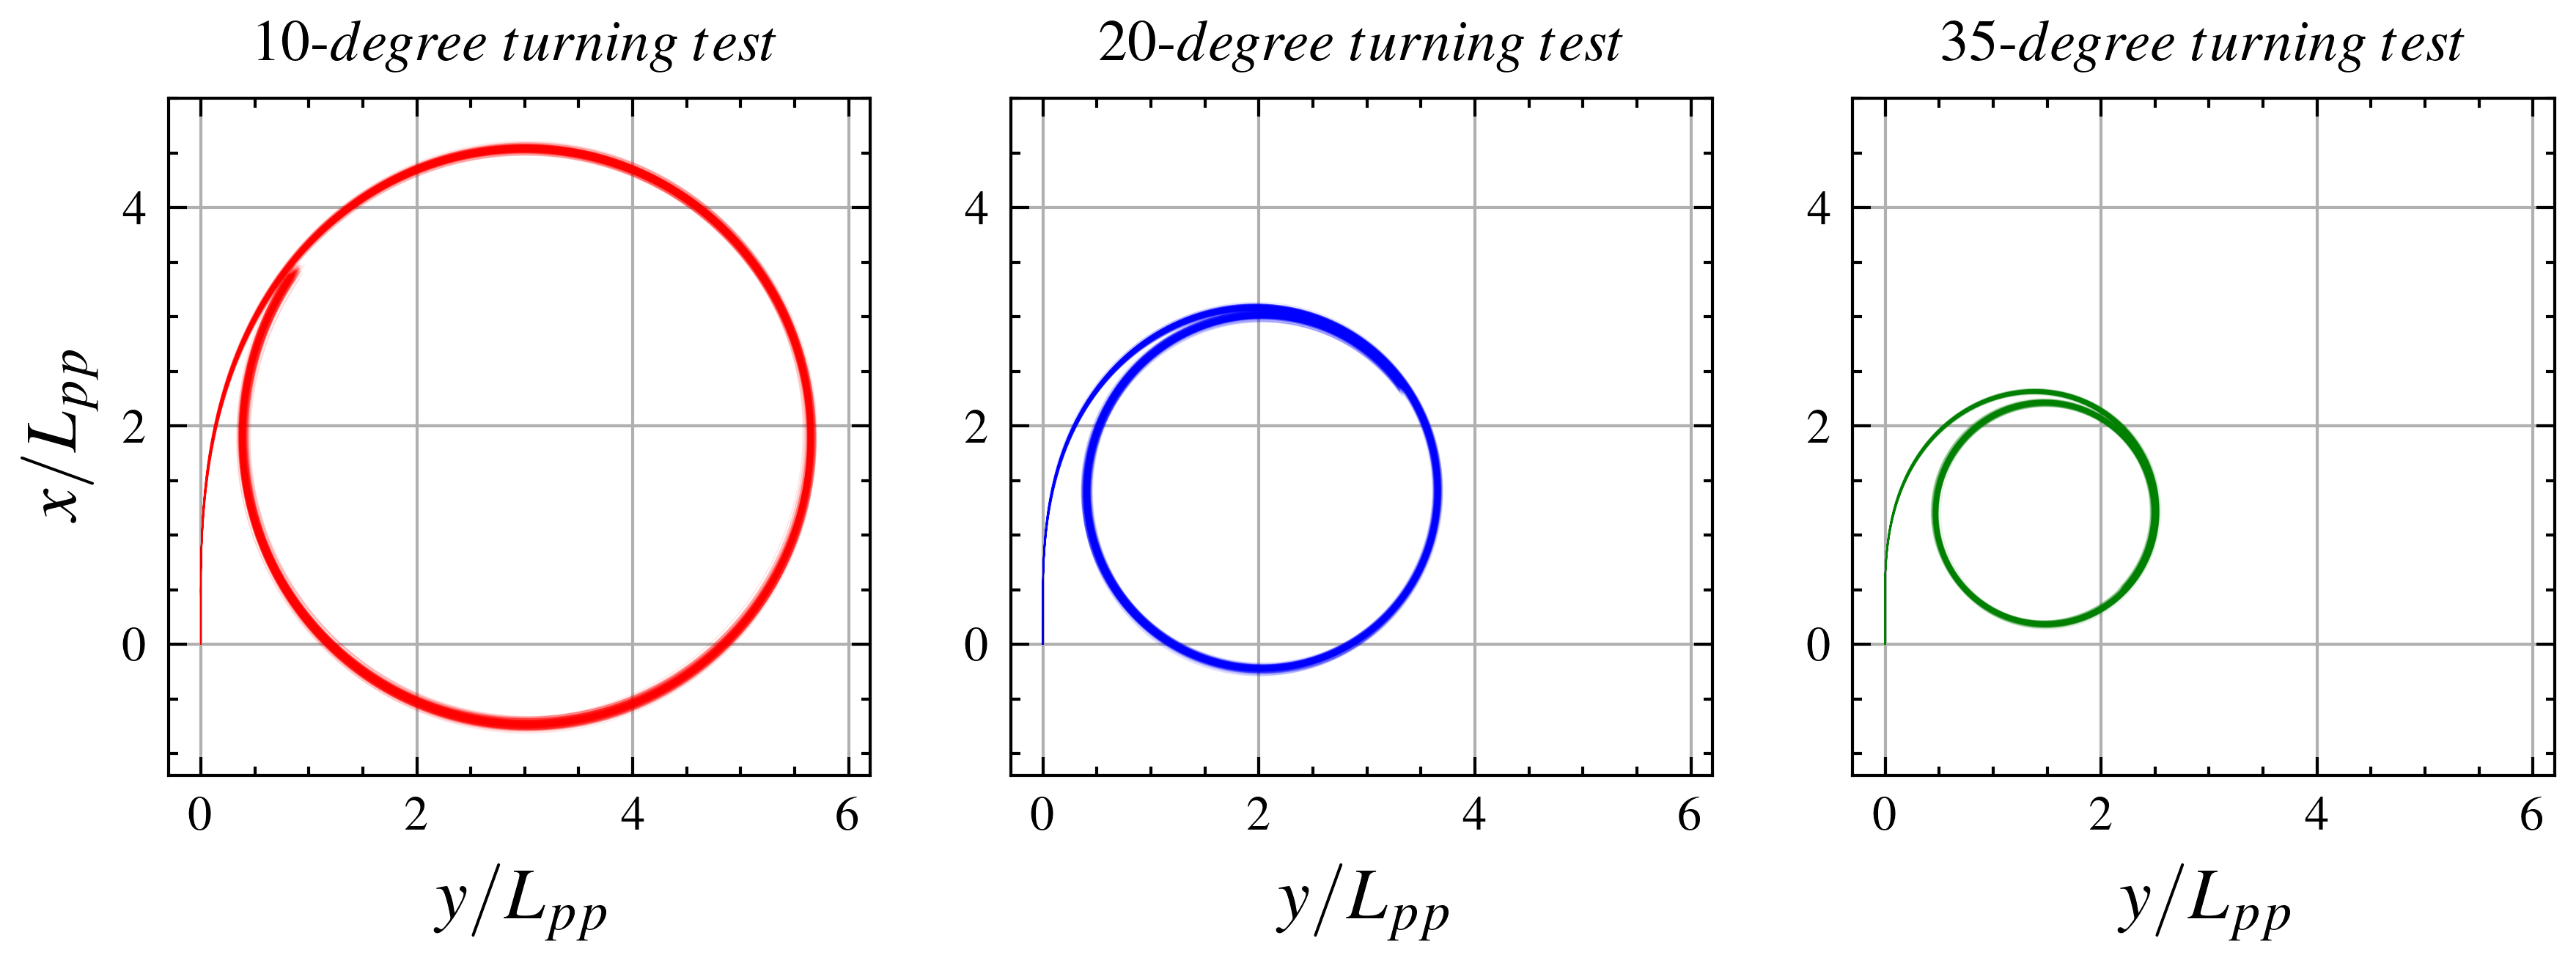

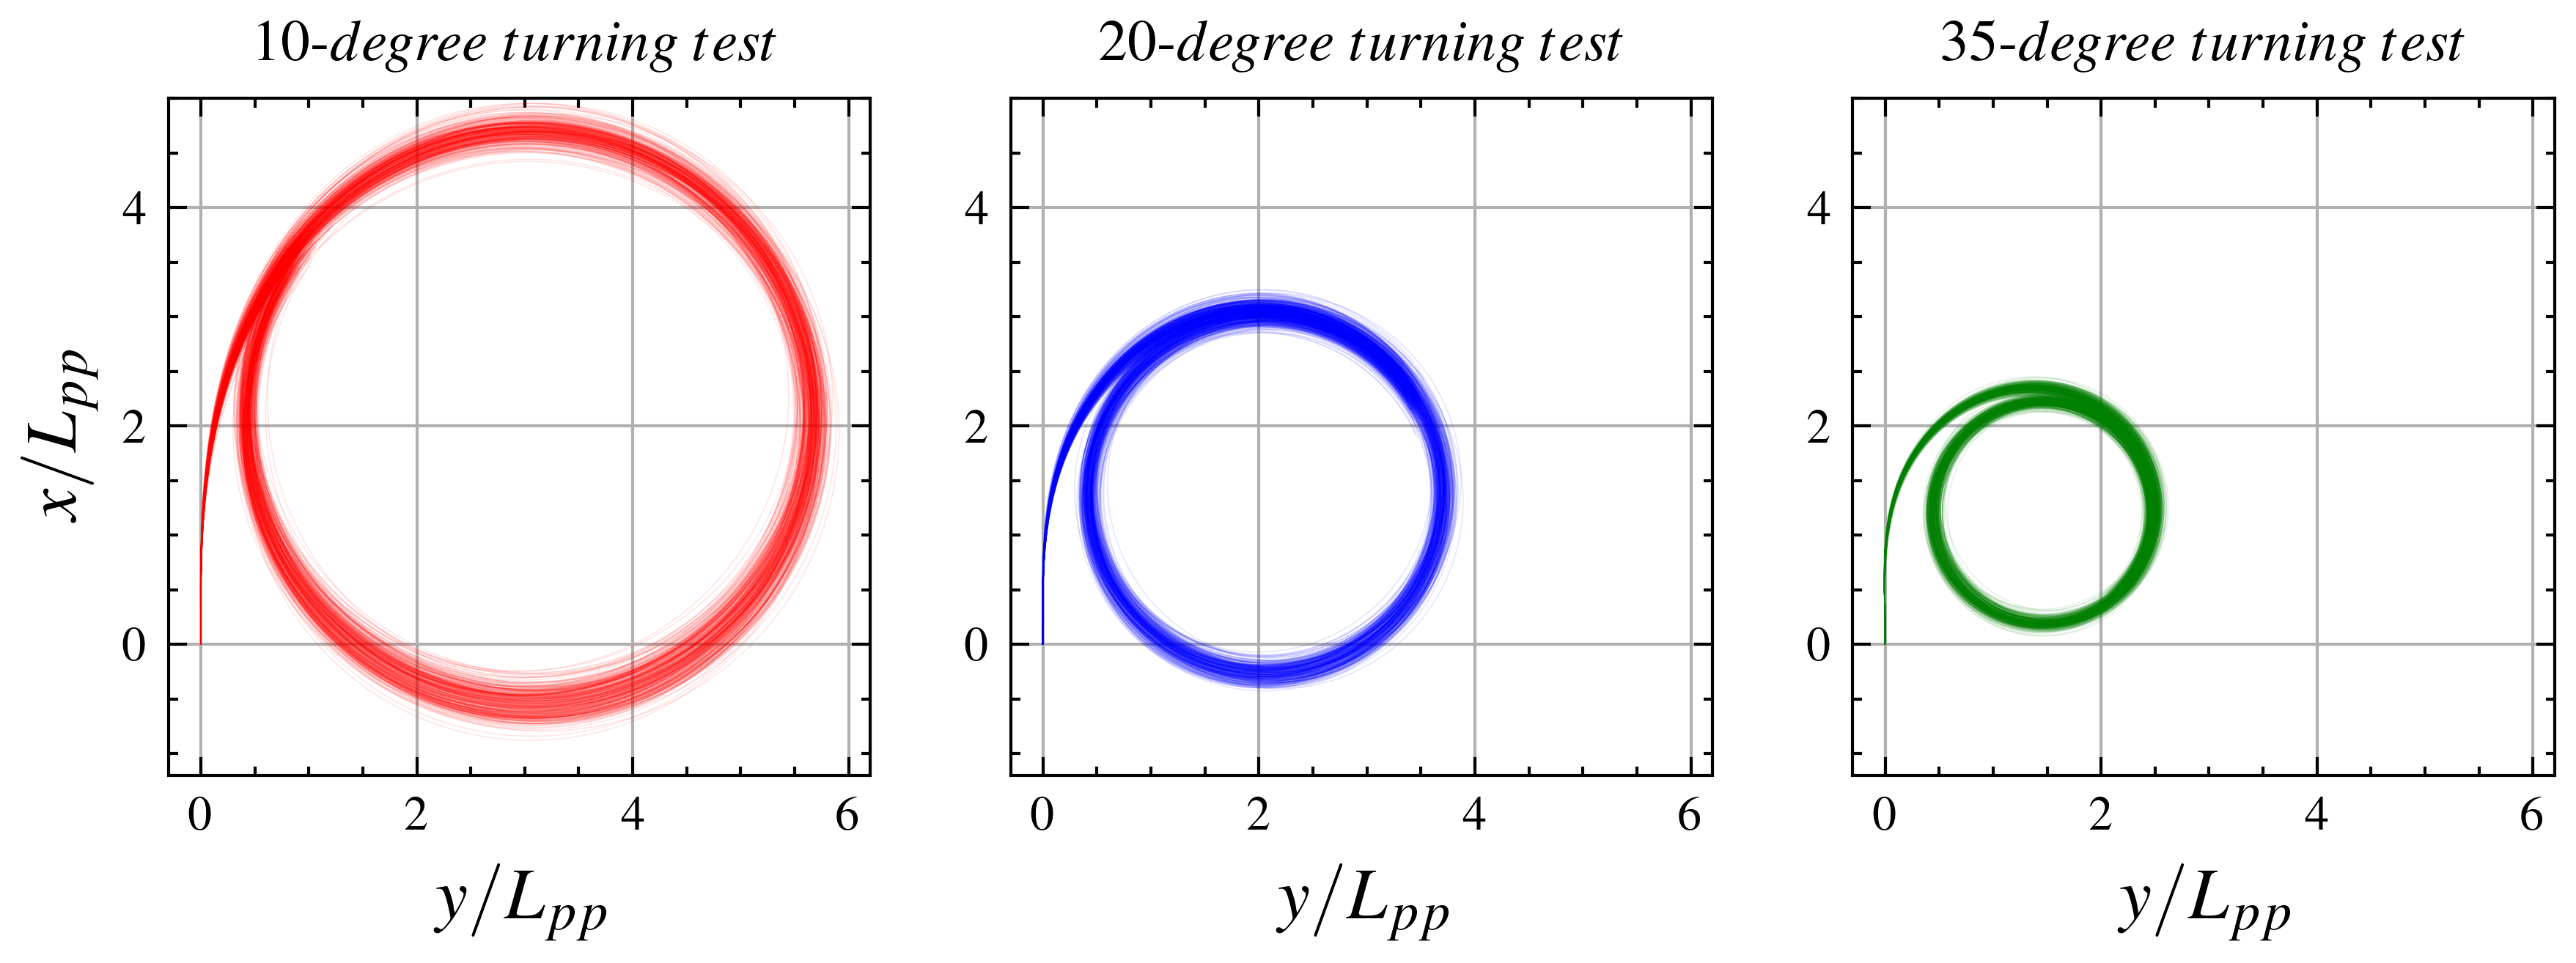

In [5]:
plt.style.use(["science", "ieee"])

fig = plt.figure(figsize=(7, 2))
ax = fig.add_subplot(1, 3, 1)
for i in num1:num2
    ax.plot(results_L2_10deg.data1[i][1:sampling,"y"]/L_pp, results_L2_10deg.data1[i][1:sampling,"x"]/L_pp, "-", alpha=0.1,  c="r", linewidth=0.2)
end
ax.set_title(L"10\mathchar`-degree~turning~test")
ax.set_ylabel(L"x/L_{pp}", fontsize=12)
ax.set_xlabel(L"y/L_{pp}", fontsize=12)
ax.set_xlim(-0.3, 6.2)
ax.set_ylim(-1.2,5)
ax.grid()

ax = fig.add_subplot(1, 3, 2)
for i in num1:num2
    ax.plot(results_L2_20deg.data5[i][1:sampling,"y"]/L_pp, results_L2_20deg.data5[i][1:sampling,"x"]/L_pp, "-", alpha=0.1,  c="b", linewidth=0.2)
end
ax.set_title(L"20\mathchar`-degree~turning~test")
ax.set_xlabel(L"y/L_{pp}", fontsize=12)
ax.set_xlim(-0.3, 6.2)
ax.set_ylim(-1.2,5)
ax.grid()

ax = fig.add_subplot(1, 3, 3)
for i in num1:num2
    ax.plot(results_L2_35deg.data9[i][1:sampling,"y"]/L_pp, results_L2_35deg.data9[i][1:sampling,"x"]/L_pp, "-", alpha=0.1,  c="g", linewidth=0.2)
end
ax.set_title(L"35\mathchar`-degree~turning~test")
ax.set_xlabel(L"y/L_{pp}", fontsize=12)
ax.set_xlim(-0.3, 6.2)
ax.set_ylim(-1.2,5)
ax.grid()
display(fig)



fig = plt.figure(figsize=(7, 2))
ax = fig.add_subplot(1, 3, 1)
for i in num1:num2
    ax.plot(results_L3_10deg.data3[i][1:sampling,"y"]/L_pp, results_L3_10deg.data3[i][1:sampling,"x"]/L_pp, "-", alpha=0.1,  c="r", linewidth=0.2)
end
ax.set_title(L"10\mathchar`-degree~turning~test")
ax.set_ylabel(L"x/L_{pp}", fontsize=12)
ax.set_xlabel(L"y/L_{pp}", fontsize=12)
ax.set_xlim(-0.3, 6.2)
ax.set_ylim(-1.2,5)
ax.grid()

ax = fig.add_subplot(1, 3, 2)
for i in num1:num2
    ax.plot(results_L3_20deg.data7[i][1:sampling,"y"]/L_pp, results_L3_20deg.data7[i][1:sampling,"x"]/L_pp, "-", alpha=0.1,  c="b", linewidth=0.2)
end
ax.set_title(L"20\mathchar`-degree~turning~test")
ax.set_xlabel(L"y/L_{pp}", fontsize=12)
ax.set_xlim(-0.3, 6.2)
ax.set_ylim(-1.2,5)
ax.grid()

ax = fig.add_subplot(1, 3, 3)
for i in num1:num2
    ax.plot(results_L3_35deg.data11[i][1:sampling,"y"]/L_pp, results_L3_35deg.data11[i][1:sampling,"x"]/L_pp, "-", alpha=0.1,  c="g", linewidth=0.2)
end
ax.set_title(L"35\mathchar`-degree~turning~test")
ax.set_xlabel(L"y/L_{pp}", fontsize=12)
ax.set_xlim(-0.3, 6.2)
ax.set_ylim(-1.2,5)
ax.grid()
display(fig)

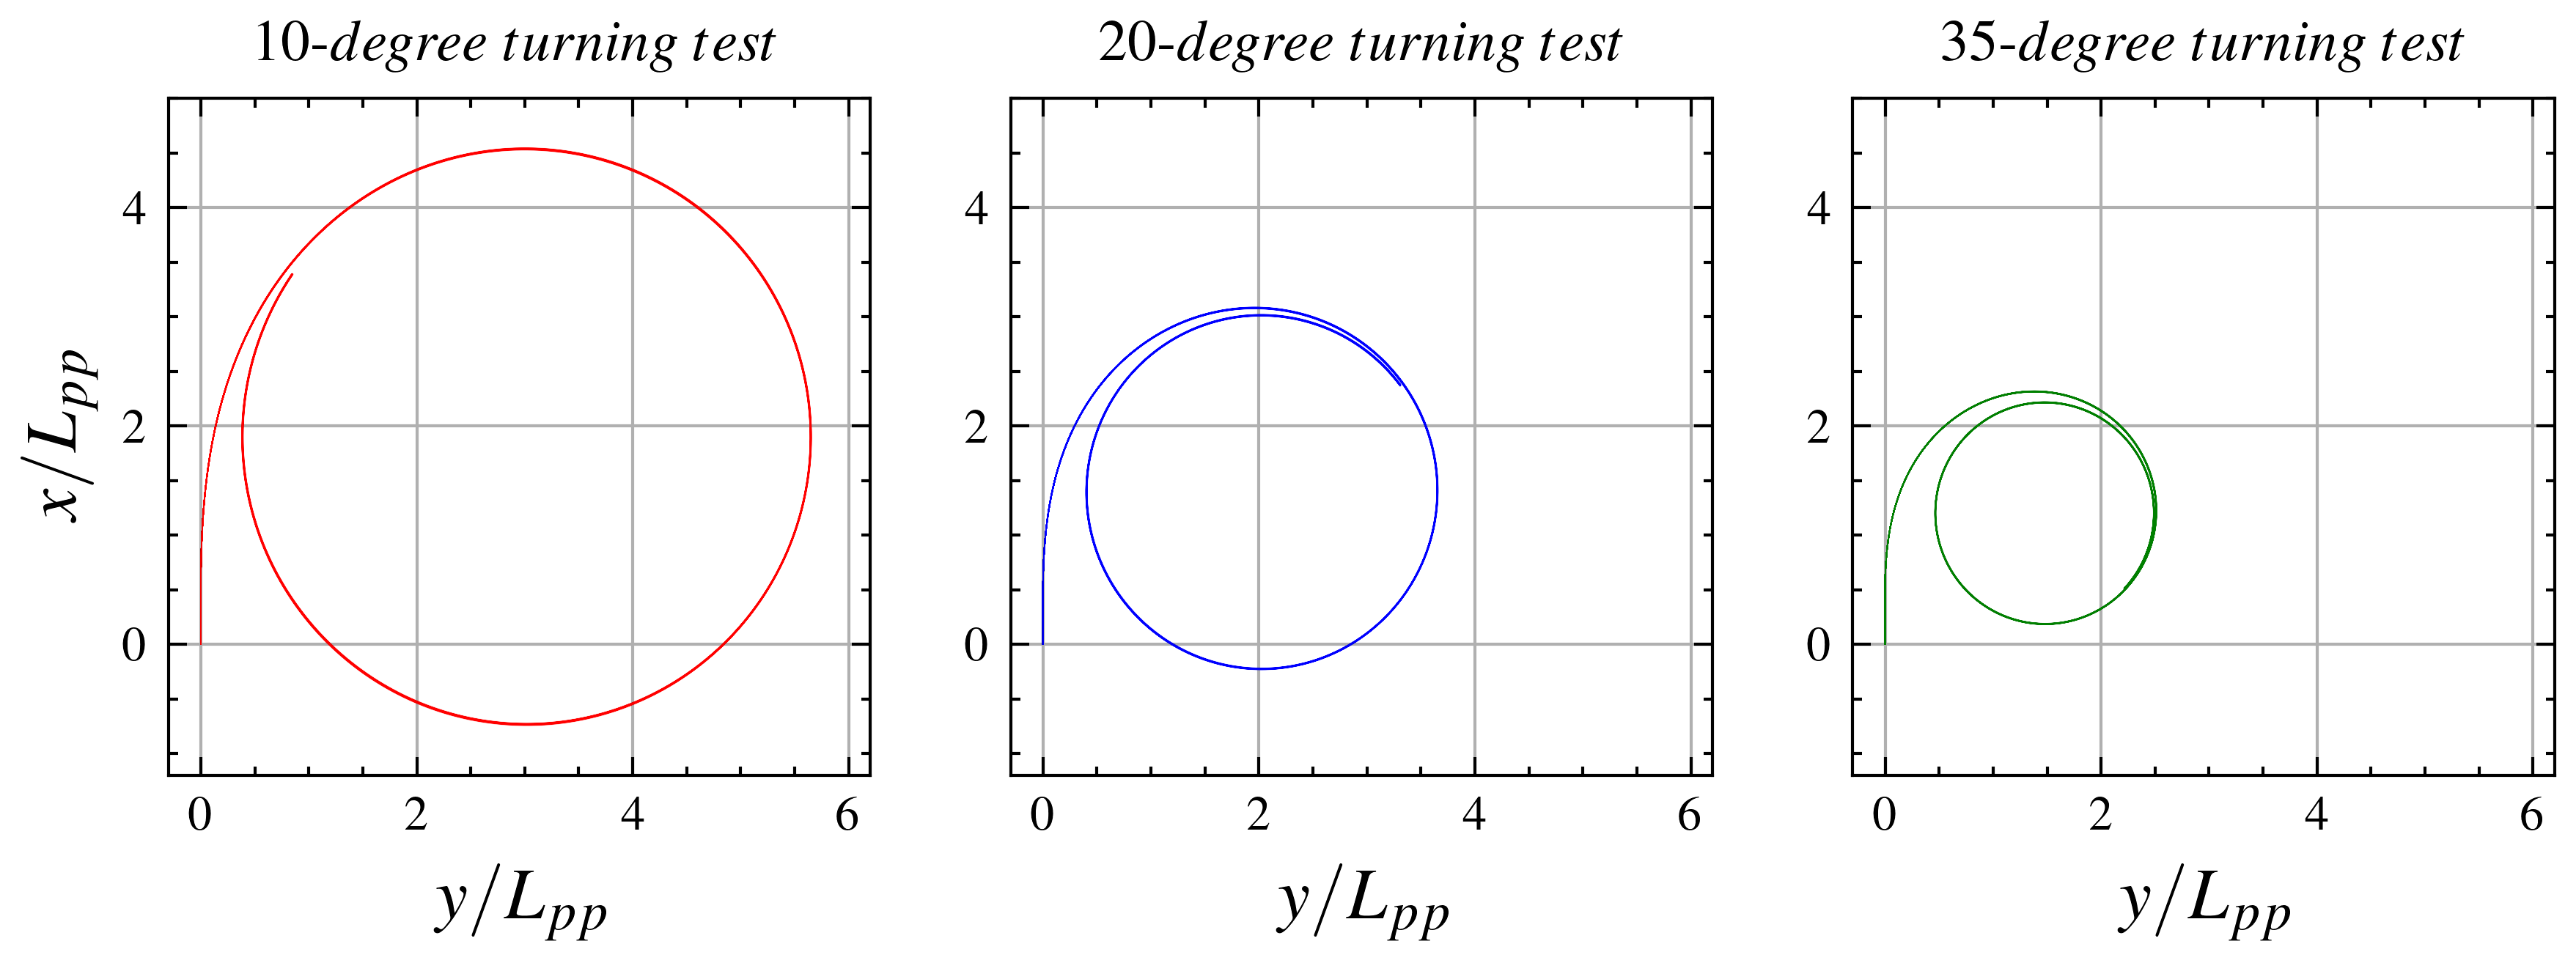

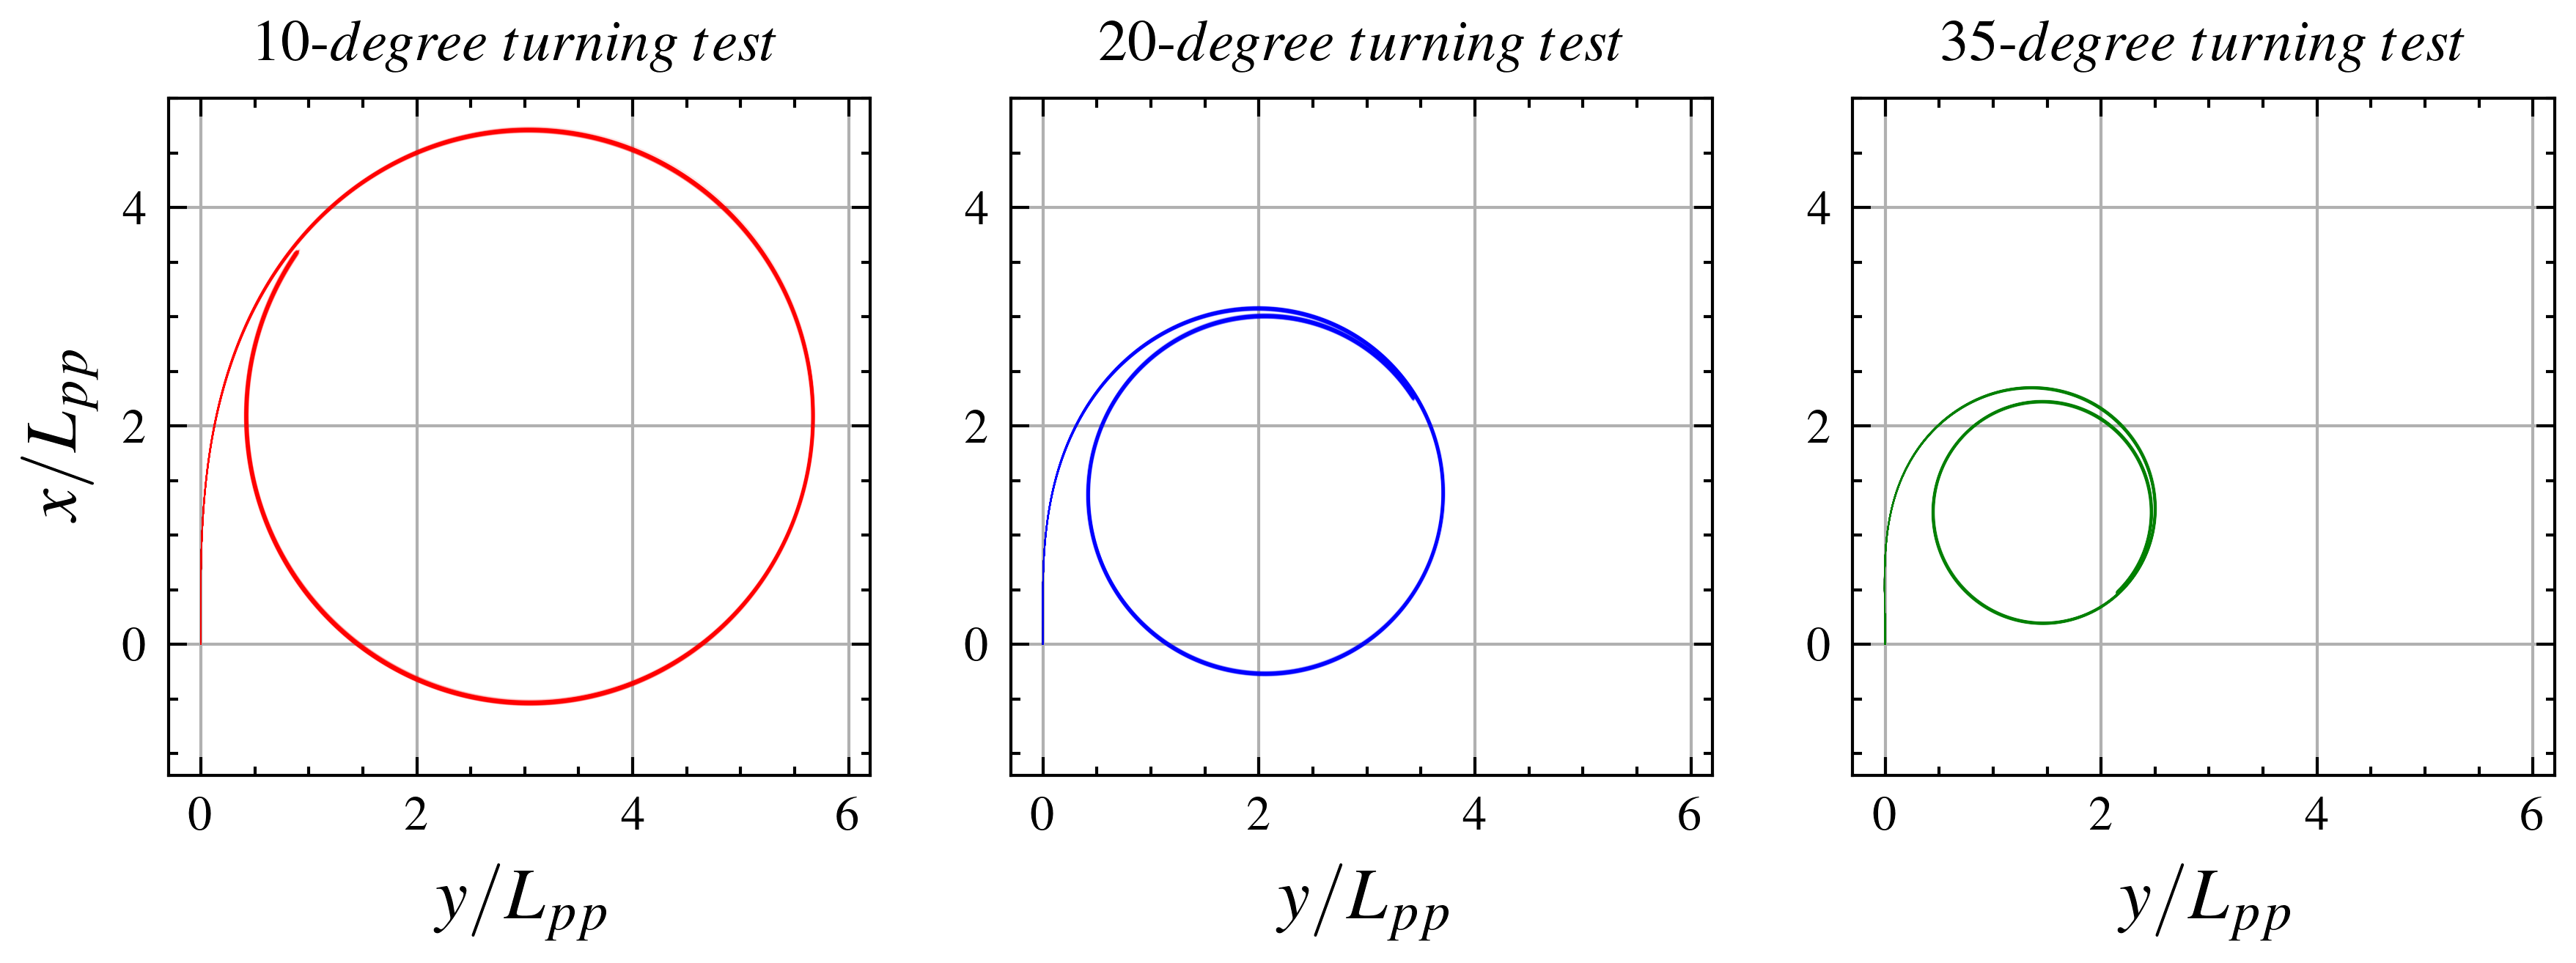

In [6]:
plt.style.use(["science", "ieee"])

fig = plt.figure(figsize=(7, 2))
ax = fig.add_subplot(1, 3, 1)
for i in num1:num2
    ax.plot(results_L2_10deg_r.data2[i][1:sampling,"y"]/L_pp, results_L2_10deg_r.data2[i][1:sampling,"x"]/L_pp, "-", alpha=0.1,  c="r", linewidth=0.2)
end
ax.set_title(L"10\mathchar`-degree~turning~test")
ax.set_ylabel(L"x/L_{pp}", fontsize=12)
ax.set_xlabel(L"y/L_{pp}", fontsize=12)
ax.set_xlim(-0.3, 6.2)
ax.set_ylim(-1.2,5)
ax.grid()

ax = fig.add_subplot(1, 3, 2)
for i in num1:num2
    ax.plot(results_L2_20deg_r.data6[i][1:sampling,"y"]/L_pp, results_L2_20deg_r.data6[i][1:sampling,"x"]/L_pp, "-", alpha=0.1,  c="b", linewidth=0.2)
end
ax.set_title(L"20\mathchar`-degree~turning~test")
ax.set_xlabel(L"y/L_{pp}", fontsize=12)
ax.set_xlim(-0.3, 6.2)
ax.set_ylim(-1.2,5)
ax.grid()

ax = fig.add_subplot(1, 3, 3)
for i in num1:num2
    ax.plot(results_L2_35deg_r.data10[i][1:sampling,"y"]/L_pp, results_L2_35deg_r.data10[i][1:sampling,"x"]/L_pp, "-", alpha=0.1,  c="g", linewidth=0.2)
end
ax.set_title(L"35\mathchar`-degree~turning~test")
ax.set_xlabel(L"y/L_{pp}", fontsize=12)
ax.set_xlim(-0.3, 6.2)
ax.set_ylim(-1.2,5)
ax.grid()
display(fig)



fig = plt.figure(figsize=(7, 2))
ax = fig.add_subplot(1, 3, 1)
for i in num1:num2
    ax.plot(results_L3_10deg_r.data4[i][1:sampling,"y"]/L_pp, results_L3_10deg_r.data4[i][1:sampling,"x"]/L_pp, "-", alpha=0.1,  c="r", linewidth=0.2)
end
ax.set_title(L"10\mathchar`-degree~turning~test")
ax.set_ylabel(L"x/L_{pp}", fontsize=12)
ax.set_xlabel(L"y/L_{pp}", fontsize=12)
ax.set_xlim(-0.3, 6.2)
ax.set_ylim(-1.2,5)
ax.grid()

ax = fig.add_subplot(1, 3, 2)
for i in num1:num2
    ax.plot(results_L3_20deg_r.data8[i][1:sampling,"y"]/L_pp, results_L3_20deg_r.data8[i][1:sampling,"x"]/L_pp, "-", alpha=0.1,  c="b", linewidth=0.2)
end
ax.set_title(L"20\mathchar`-degree~turning~test")
ax.set_xlabel(L"y/L_{pp}", fontsize=12)
ax.set_xlim(-0.3, 6.2)
ax.set_ylim(-1.2,5)
ax.grid()

ax = fig.add_subplot(1, 3, 3)
for i in num1:num2
    ax.plot(results_L3_35deg_r.data12[i][1:sampling,"y"]/L_pp, results_L3_35deg_r.data12[i][1:sampling,"x"]/L_pp, "-", alpha=0.1,  c="g", linewidth=0.2)
end
ax.set_title(L"35\mathchar`-degree~turning~test")
ax.set_xlabel(L"y/L_{pp}", fontsize=12)
ax.set_xlim(-0.3, 6.2)
ax.set_ylim(-1.2,5)
ax.grid()
display(fig)